In [76]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Titanic Survival Predictions
In this dataset, we will train a logistic regression model that can predict the survivors based on a set of features about the passenger. Start first by taking sometime to understand your data. You can find more info about the data and its breakdown in this link https://www.kaggle.com/c/titanic/data

### Start with Data Exploring
Our data is split into two files. One for training and one for testing. Load both and find out the number of samples and features in each file

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, tree, preprocessing, metrics
import sklearn.ensemble as ske


df_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")
df_test.head()
df_test.info()
df_train.head()
df_train.info()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 27.8+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


How many survivors in the traning set?

In [96]:
count = 0
for i in df_train['Survived']:
    if i ==1:
        count+=1  
print(count, 'people survived ')
    

342 people survived 


find Jack and Rose in the data? Use a code. You probably won't find them as they were fictional charachter. See if you can find Beatrice Irene Sandstorm? Read here about her https://www.encyclopedia-titanica.org/titanic-survivor/beatrice-irene-sandstrom.html

In [97]:
df_train[df_train['Name'].str.contains(r"Jack|Rose|Beatrice")]
df_test[df_test['Name'].str.contains(r"Jack|Rose|Beatrice")]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
766,767,0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.60,NaN,C
855,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.35,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
117,1009,3,"Sandstrom, Miss. Beatrice Irene",female,1.0,1,1,PP 9549,16.7000,G6,S
208,1100,1,"Rosenbaum, Miss. Edith Louise",female,33.0,0,0,PC 17613,27.7208,A11,C
327,1219,1,"Rosenshine, Mr. George (Mr George Thorne"")""",male,46.0,0,0,PC 17585,79.2000,NaN,C


### Does features make difference?
In the training dataset 
- Pclass - Usually, higher class (class 1) meant a more expensive fare and the other classes paid lesser to be on the ship. What was the survival rate per class?
- Sex — What was the survival rate of women?
- SibSp — What was the survival rate based on number of siblings the passenger had on the ship?
- Parch — What was the survival rate based on number of parents/children the passenger had on the ship?

In [98]:
print(df_train.groupby('Pclass').mean())
print(df_train.groupby('Sex').mean())
print(df_train.groupby('SibSp').mean())
print(df_train.groupby('Parch').mean())

feature_grouping = df_train.groupby(['Pclass','Sex', 'SibSp', 'Parch']).mean()
feature_grouping

        PassengerId  Survived        Age     SibSp     Parch       Fare
Pclass                                                                 
1        461.597222  0.629630  38.233441  0.416667  0.356481  84.154687
2        445.956522  0.472826  29.877630  0.402174  0.380435  20.662183
3        439.154786  0.242363  25.140620  0.615071  0.393075  13.675550
        PassengerId  Survived    Pclass        Age     SibSp     Parch  \
Sex                                                                      
female   431.028662  0.742038  2.159236  27.915709  0.694268  0.649682   
male     454.147314  0.188908  2.389948  30.726645  0.429809  0.235702   

             Fare  
Sex                
female  44.479818  
male    25.523893  
       PassengerId  Survived    Pclass        Age     Parch       Fare
SibSp                                                                 
0       455.370066  0.345395  2.351974  31.397558  0.185855  25.692028
1       439.727273  0.535885  2.057416  30.089727 

PassengerId  Survived        Age        Fare
Pclass Sex    SibSp Parch                                              
1      female 0     0       465.676471  0.970588  34.937500  105.960538
                    1       515.100000  1.000000  35.555556  117.217500
                    2       424.600000  1.000000  25.200000   78.260000
              1     0       417.137931  1.000000  37.434783   84.318966
                    1       692.428571  1.000000  43.000000  102.730357
                    2       499.250000  0.500000  19.250000  135.775000
              2     0       572.000000  1.000000  53.000000   51.479200
                    2       527.500000  1.000000  19.500000  262.375000
              3     2       215.500000  1.000000  23.500000  263.000000
       male   0     0       484.253333  0.333333  44.601852   44.501943
                    1       215.888889  0.222222  38.777778  142.700467
                    2       508.750000  0.500000  26.500000  129.379150
              1     0       449.227273  0.454545  36.954545   69.437886
                    1       509.000000  0.400000  53.600000   78.657500
                    2       500.000000  1.000000  15.973333  130.516667
                    4       439.000000  0.000000  64.000000  263.000000
              2     0       453.500000  0.500000  47.000000  111.825000
              3     2        28.000000  0.000000  19.000000  263.000000
2      female 0     0       399.031250  0.906250  33.383333   13.793491
                    1       476.142857  1.000000  26.714286   24.285714
                    2       389.400000  1.000000  18.000000   21.200000
              1     0       423.333333  0.833333  28.916667   24.744092
                    1       536.777778  0.888889  25.444444   28.666667
                    2       426.000000  1.000000  22.500000   44.776400
                    3       775.000000  1.000000  54.000000   23.000000
              2     1       610.000000  1.000000  14.000000   33.000000
                    3       438.000000  1.000000  24.000000   18.750000
              3     0       727.000000  1.000000  30.000000   21.000000
       male   0     0       446.777778  0.097222  33.904762   14.187268
                    1       849.000000  0.000000  28.000000   33.000000
...                                ...       ...        ...         ...
3      female 1     2       889.000000  0.000000        NaN   23.450000
                    3       737.000000  0.000000  48.000000   34.375000
                    4       168.000000  0.000000  45.000000   27.900000
                    5       318.500000  0.500000  38.500000   31.331250
                    6       679.000000  0.000000  43.000000   46.900000
              2     0       185.000000  0.500000  18.000000   20.625000
                    1       521.333333  1.000000   2.166667   19.258300
                    2       292.500000  0.000000  15.000000   34.375000
              3     0        86.000000  1.000000  33.000000   15.850000
                    1       305.200000  0.000000   5.500000   23.710020
                    2       639.000000  0.000000   5.500000   27.900000
              4     2       387.000000  0.333333   8.333333   27.402083
              5     2        72.000000  0.000000  16.000000   46.900000
              8     2       612.666667  0.000000        NaN   69.550000
       male   0     0       473.265152  0.121212  29.184492    9.507808
                    1       478.750000  0.500000  23.105000   11.373975
                    2       160.000000  0.500000  24.750000   17.512500
              1     0       417.625000  0.125000  24.823529   13.146188
                    1       486.200000  0.400000  20.230769   15.101113
                    2       555.666667  0.333333  13.500000   21.533333
                    3        87.000000  0.000000  16.000000   34.375000
                    4       361.000000  0.000000  40.000000   27.900000
                    5        14.000000  0.000000  39.000000   31.27

Plot two histogram based on the age. One for the survivors and other for non survivors. According to the histogram was Jack more likely to survive or not survive and why?

Text(0.5, 0, 'Age')

Text(0, 0.5, 'Frequency')

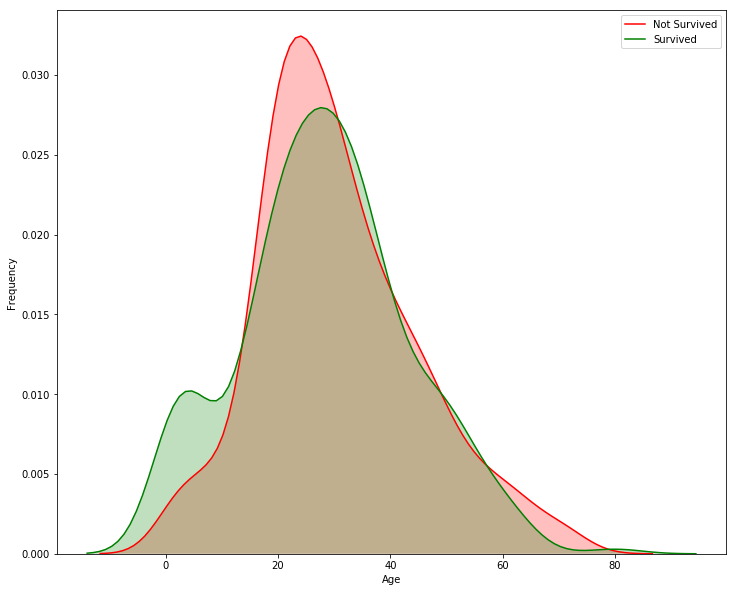

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams["figure.figsize"] = [12,10] # increase the size
g = sns.kdeplot(df_train["Age"][(df_train["Survived"] == 0) & (df_train["Age"].notnull())], color="r", shade = True)
g = sns.kdeplot(df_train["Age"][(df_train["Survived"] == 1) & (df_train["Age"].notnull())], ax =g, color="g", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

Divide the age histograms on a 3 X 2 subplots. Left column is for non survival data and the right one is for survivors. Each row is for one of the three PClasses

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1E9352B0>,
      dtype=object)

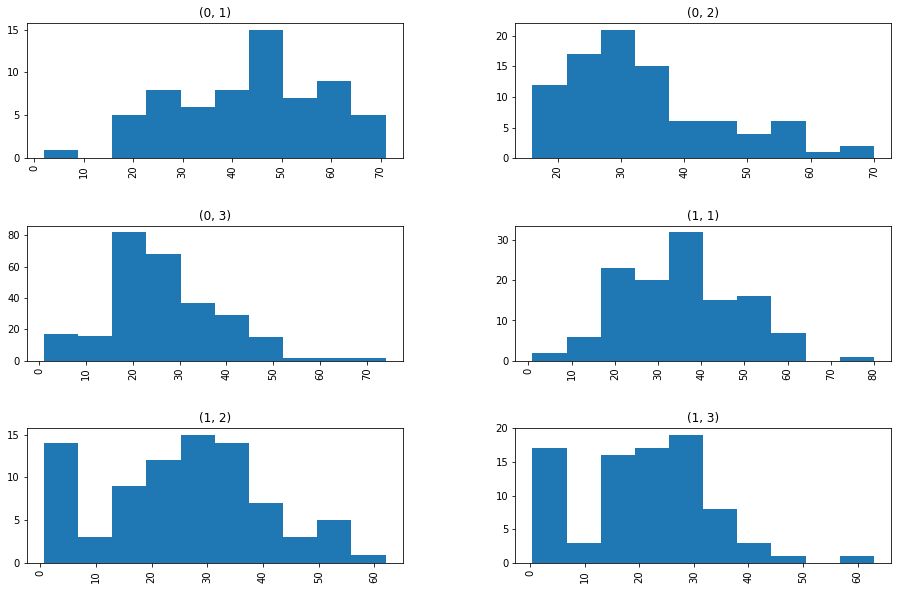

In [100]:
df_train.hist("Age", bins=10, by = ["Survived", "Pclass"],figsize = [15,10])

## Fix missing Data in the Training Dataset
Which features in the training contains missing values? and how many missing values are there?

In [101]:
count_nan = len(df_train) - df_train.count()
count_nan

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Find out the age median grouped by PClass and gender. Clean up the data by substituting the nans by the median from the corresponding PClass and gender

In [102]:
median_grouped = df_train.groupby(by=['Pclass', 'Sex']).Age.median()
print(median_grouped)
# replace .. using a for loop that picks nan elements from each pclass I am replacing the male and female ages
for p in df_train.Pclass.unique(): 
    df_train.Age[(df_train.Pclass==p) & (df_train.Age.isna()) & (df_train.Sex==1)] = median_grouped[p][1]
    df_train.Age[(df_train.Pclass==p) & (df_train.Age.isna()) & (df_train.Sex==0)] = median_grouped[p][0]   
#Checking if we still have any nans in age
print('number of nans in age is ', df_train.Age.isna().sum())

Pclass  Sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: Age, dtype: float64


C:\Users\Mudabbir\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Mudabbir\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


number of nans in age is  177


For the Embarked column, substitute the missing value with the highest occurance value among the entire dataset

In [103]:
df_train['Embarked']= df_train['Embarked'].fillna("S")


# Let's do our Model
Cabin, Name, ticket and Passenger Id are not important to our ML model. Let's get rid of them

In [104]:
df_train = df_train.drop(['Name','Cabin','Ticket', 'PassengerId'], axis=1)

Make sure now that your data does not have any nulls

In [105]:
df_train = df_train.dropna()

print(df_train.isnull().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


We need to convert some of our features to categories and numbers instead of letters as logistic regression model won't be able to decode them. Map the embarked variable into 0,1, and 2 and the sex variable into 0 and 1

% hint: `df_train['Embarked'].astype('category').cat.codes`

In [106]:
df_train['Embarked']=df_train['Embarked'].astype('category').cat.codes
df_train['Sex']=df_train['Sex'].astype('category').cat.codes
df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2
6,0,1,1,54.0,0,0,51.8625,2
7,0,3,1,2.0,3,1,21.0750,2
8,1,3,0,27.0,0,2,11.1333,2
9,1,2,0,14.0,1,0,30.0708,0
10,1,3,0,4.0,1,1,16.7000,2


You are now ready to build a logistic regression model and fit it 

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X = df_train.loc[:, df_train.columns != 'Survived']
Y = df_train['Survived']
scaler=StandardScaler().fit(X)
x_scaled=scaler.transform(X)


C:\Users\Mudabbir\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Mudabbir\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  


In [108]:
from sklearn.linear_model import LogisticRegression
logreg =  LogisticRegression().fit(x_scaled, Y)

C:\Users\Mudabbir\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Show the training score. 

In [109]:
logreg.score(x_scaled,Y)

0.8025210084033614

What are the coefficients. Make a plot that shows the importance of each feature in your model

coefficient and bias are : [[-0.99834921 -1.24524591 -0.60907688 -0.32626496 -0.04929782  0.08821397
  -0.13302251]] and [-0.50134591]


<BarContainer object of 7 artists>

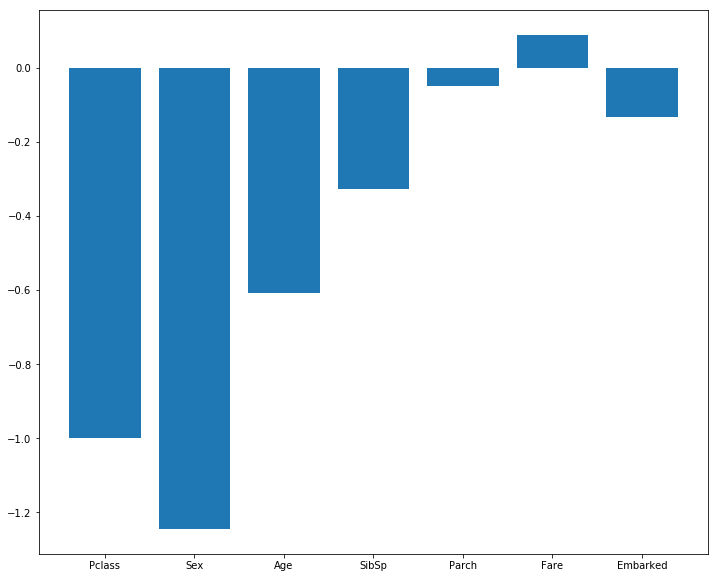

In [110]:
print('coefficient and bias are :',logreg.coef_,'and', logreg.intercept_) # print w and b
# bar plot to show the importance
plt.bar(X.columns, logreg.coef_[0])

Use the logistic regression model on the test data to predict who will survive. You may need to do same cleaning you have done in the training data to the test data

In [111]:
for p in df_test.Pclass.unique(): 
    df_test.Age[(df_test.Pclass==p) & (df_test.Age.isna()) & (df_test.Sex==1)] = median_grouped[p][1]
    df_test.Age[(df_test.Pclass==p) & (df_test.Age.isna()) & (df_test.Sex==0)] = median_grouped[p][0]   
df_test.Embarked[df_test.Embarked.isna()]=df_train.Embarked.value_counts().idxmax()
df_test.drop(columns=['Cabin','Name','Ticket','PassengerId'], inplace=True)
df_test.Embarked = df_test.Embarked.astype('category').cat.codes
df_test.Sex = df_test.Sex.astype('category').cat.codes
print(df_test.isna().sum())
df_test.dropna(inplace=True)
print(df_test.isna().sum())

C:\Users\Mudabbir\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Mudabbir\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


C:\Users\Mudabbir\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [112]:
x_scaled_test=scaler.transform(df_test)
pred = logreg.predict(x_scaled_test)

C:\Users\Mudabbir\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


How many will survive from the test dataset?

In [113]:
print("only {} survived.".format(sum(y_predict==1)))

only 7 survived.
